In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
! pip install scipy==1.3.2

     |████████████████████████████████| 25.2MB 127kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
! pip install sporco

     |████████████████████████████████| 4.4MB 2.8MB/s 
     |████████████████████████████████| 2.6MB 43.7MB/s 


In [3]:
! pip install opencv-python

In [4]:
! pip install tensorflow 

In [6]:
pip install tensorflow -U

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 450kB 49.9MB/s 
     |████████████████████████████████| 3.8MB 60.3MB/s 
     |████████████████████████████████| 26.1MB 117kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: scipy 1.3.2
    Uninstalling scipy-1.3.2:
      Successfully uninstalled scipy-1.3.2
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
from __future__ import print_function
from builtins import input
from builtins import range

#import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np
import tensorflow as tf
import functools
import operator
import matplotlib.pyplot as mplot
mplot.rcParams["axes.grid"] = False
import math
import pprint
import os
import shutil
import time

from scipy.linalg import toeplitz
from sporco.dictlrn import cbpdndl
from sporco.admm import cbpdn
from sporco import util
from sporco import plot
from sporco import cnvrep
import sporco.linalg as sl
import sporco.metric as sm
from sporco.admm import ccmod
from skimage.measure import compare_ssim
from skimage.measure import compare_psnr
plot.config_notebook_plotting()

import myutil
import sugano_solve
# import nakashizuka_solve
import datetime
import os
from torchvision import datasets
import cv2

In [0]:
# MNIST : 合計で学習用60000枚, テスト用10000枚
def load_mnist_train(train_amount):
    data = datasets.MNIST("../data", download = True)
    imgs, labels = data.train_data.numpy() , data.train_labels.numpy()
    return_data = np.zeros((imgs.shape[0], 32, 32))
    for i in range(imgs.shape[0]):
        return_data[i] = cv2.copyMakeBorder(imgs[i],2,2,2,2,cv2.BORDER_CONSTANT, value=0)
    idx = np.random.choice(len(return_data), train_amount, replace=False)
    return return_data[idx]/255.0, labels[idx]

def load_mnist_test(test_amount):
    data = datasets.MNIST("../data", download = True)
    imgs, labels = data.test_data.numpy(), data.test_labels.numpy()
    return_data = np.zeros((imgs.shape[0], 32, 32))
    for i in range(imgs.shape[0]):
        return_data[i] = cv2.copyMakeBorder(imgs[i],2,2,2,2,cv2.BORDER_CONSTANT, value=0)
    idx = np.random.choice(len(return_data), test_amount, replace=False)
    return return_data[idx]/255.0, labels[idx]

# fashion-MNIST : 全部で学習用60000枚, テスト用10000枚
def load_fashion_mnist_train(train_amount):
    data = datasets.FashionMNIST("../data", download = True)
    imgs, labels = data.train_data.numpy() , data.train_labels.numpy()
    return_data = np.zeros((imgs.shape[0], 32, 32))
    for i in range(imgs.shape[0]):
        return_data[i] = cv2.copyMakeBorder(imgs[i],2,2,2,2,cv2.BORDER_CONSTANT, value=0)
    idx = np.random.choice(len(return_data), train_amount, replace=False)
    return return_data[idx]/255.0, labels[idx]

def load_fashion_mnist_test(test_amount):
    data = datasets.FashionMNIST("../data", download = True)
    imgs, labels = data.test_data.numpy(), data.test_labels.numpy()
    return_data = np.zeros((imgs.shape[0], 32, 32))
    for i in range(imgs.shape[0]):
        return_data[i] = cv2.copyMakeBorder(imgs[i],2,2,2,2,cv2.BORDER_CONSTANT, value=0)
    idx = np.random.choice(len(return_data), test_amount, replace=False)
    return return_data[idx]/255.0, labels[idx]

def getimages():
    exim = util.ExampleImages(scaled=True, zoom=0.5, gray=True)
    S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
    S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
    S3 = exim.image('monarch.png', idxexp=np.s_[:, 160:672])
    S4 = exim.image('sail.png', idxexp=np.s_[:, 210:722])
    S5 = exim.image('tulips.png', idxexp=np.s_[:, 30:542])
    return np.dstack((S1, S2, S3, S4, S5))

In [3]:
# データセットの読み込み
# train_data, train_label = load_mnist_train(1000)
# test_data, test_label = load_mnist_test(10000)
train_data, train_label = load_fashion_mnist_train(1000)
test_data, test_label = load_fashion_mnist_test(10000)
# S = getimages().astype(np.float32)

# (x, y, 枚数)の形にリシェイプ
train_data = train_data.transpose(1,2,0)
test_data = test_data.transpose(1,2,0)

def subtract_mean(S):
    Sl = np.zeros_like(S)
    Smean = np.mean(S*2, axis=(0, 1))
    return S*2 - Smean

# 画素値の平均を0にする
train_data = subtract_mean(train_data)
test_data = subtract_mean(test_data)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
# 第１層の畳み込み辞書学習問題を解く。

# 辞書を初期化
# dsz = (12, 12, 256) # フィルタサイズが同一
# dsz = ((3, 3, 2), (5, 5, 2), (7, 7, 2)) # フィルタサイズが異なる
# dsz = ((4, 4, 2), (6, 6, 2), (8, 8, 2)) # フィルタサイズが異なる
dsz = (14, 14, 6)
D = myutil.getdict(dsz) # dszで指定されたシェイプの辞書を返す

# 画像を(x, y, 枚数)の形にリシェイプ
S = train_data

# (x, y, チャネル数, 画像の枚数, 辞書の枚数)にリシェイプ
cri_train = cnvrep.CSC_ConvRepIndexing(D, S)
print("cri_test"+"\n"+str(cri_train))
D = np.asarray(D.reshape(cri_train.shpD), dtype=D.dtype)
S = np.asarray(S.reshape(cri_train.shpS), dtype=S.dtype)

# 辞書の正規化
D = cnvrep.normalise(D)

# 辞書学習
itrs = 300
non_nega = False
start = time.time()
D1, X1 = sugano_solve.convDictLearn(cri_train, D, dsz, S, 1e-9, itrs, non_nega, True)
# D1, X1 = nakashizuka_solve.convDictLearn(cri_train, D, dsz, train_data, 1e-4, maxitr=itrs)
end = time.time()
print("ConvDictLearn solve time: %.2fs" % (end - start))

cri_test
{'C': 1,
 'Cd': 1,
 'K': 1000,
 'M': 6,
 'N': 1024,
 'Nv': (32, 32),
 'axisC': 2,
 'axisK': 3,
 'axisM': 4,
 'axisN': (0, 1),
 'dimC': 0,
 'dimCd': 0,
 'dimK': 1,
 'dimN': 2,
 'shpD': (14, 14, 1, 1, 6),
 'shpS': (32, 32, 1, 1000, 1),
 'shpX': (32, 32, 1, 1000, 6)}
c = 0.92994424
sigma = 2.70012420 l0norm = 5488 alpha = 0.50000000 error = 175292269.55198 l0norm_projected = 6144
sigma = 2.51096496 l0norm = 5991 alpha = 0.25000000 error = 141254657028.68610 l0norm_projected = 6144
sigma = 2.33505741 l0norm = 5041 alpha = 0.12500000 error = 46660923.60506 l0norm_projected = 6144
sigma = 2.17147319 l0norm = 5404 alpha = 0.06250000 error = 396937.02961 l0norm_projected = 6144
sigma = 2.01934900 l0norm = 5022 alpha = 0.06250000 error = 303965.59141 l0norm_projected = 6144
sigma = 1.87788198 l0norm = 4862 alpha = 0.06250000 error = 277135.93226 l0norm_projected = 6144
sigma = 1.74632553 l0norm = 4643 alpha = 0.03125000 error = 300828.22600 l0norm_projected = 6144
sigma = 1.62398538 l0

In [0]:
print("l0norm = %i" % np.where(abs(X1.transpose(3,4,2,0,1).squeeze()[0]) < 1e-4, 0, 1).sum())

l0norm = 1773


(32, 32, 1, 1000, 6)
6144


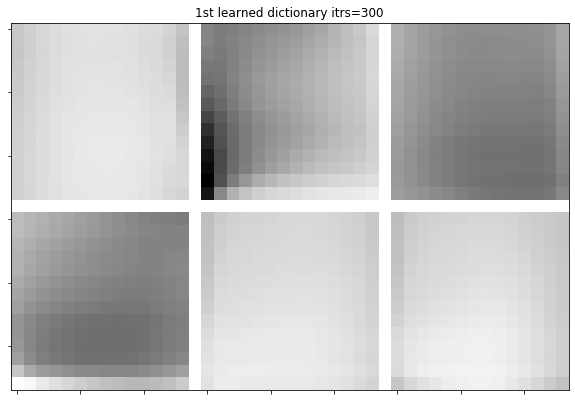

In [5]:
fig =  plot.figure(figsize=(10, 10))
plot.imview(util.tiledict(D1.squeeze()), fig=fig, title="1st learned dictionary itrs="+str(itrs))
print(X1.shape)
print(np.where(X1.squeeze().transpose(2,3,0,1)[0] == 0, 0, 1).sum())

In [30]:
! pip list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.0.1          
asgiref                  3.2.3          
astor                    0.8.1          
astropy                  4.0            
atari-py                 0.2.6          
atomicwrites             1.3.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
backports.tempfile       1.0            
backports.weakref        1.0.post1      
beautifulsoup4           4.6.3          
bleach                   3.1.0          
blis                     0.2.4          
bokeh                    1.4.0          
boto                     2.49.0         
boto3                    1.11.15        
botocore        

In [9]:
print(X1.transpose(3,4,2,0,1).squeeze().shape)


#tf.nn.max_pool2d(X1.transpose(0,1,4,3,2).squeeze(), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME').shape

(1000, 6, 32, 32)


(1000, 6, 16, 16)

In [17]:
# 第2層目の畳み込み辞書学習問題を解く。

# 辞書の初期化
dsz = (8, 8, 6, 3) # フィルタサイズが同一
# dsz = ((3, 3, 6, 5), (5, 5, 6, 6), (7, 7, 6, 5)) # フィルタサイズが異なる
# dsz = ((3, 3, 6, 3), (5, 5, 6, 3), (7, 7, 6, 3)) # フィルタサイズが異なる
D = myutil.getdict(dsz) # dszで指定されたシェイプの辞書を返す

S = tf.nn.max_pool2d(X1.transpose(3,4,2,0,1).squeeze(), ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format="NCHW").numpy().transpose(2,3,1,0)
print(S.shape)
S = subtract_mean(S)
cri_train = cnvrep.CSC_ConvRepIndexing(D, S)
print("cri_test"+"\n"+str(cri_train))
D = D.reshape(cri_train.shpD)
S = S.reshape(cri_train.shpS)

# 辞書の正規化
D = cnvrep.normalise(D)
print(myutil.l2norm(D))
# 辞書学習
itrs = 300
non_nega = False
start = time.time()
# D_split = np.split(D, cri_train.Cd, cri_train.axisC)
# S_split = np.split(S, cri_train.C, cri_train.axisC)

# print(D_split[0].shape)
# print(S_split[0].shape)
# D2 = []
# X2 = []
# for D,S in zip(D_split, S_split):
#   result = sugano_solve.convDictLearn(cri_train, D, dsz, S, 1e-7, itrs, non_nega, True)
#   D2.append(result[0])
#   X2.append(result[1])
D2, X2 = sugano_solve.convDictLearn(cri_train, D, dsz, S, 1e-12, itrs, non_nega, True)
# D2 = np.concatenate(D2, cri_train.axisC)
# X2 = np.concatenate(X2, cri_train.axisC)
end = time.time()
print("ConvDictLearn solve time: %.2fs" % (end - start))

(16, 16, 6, 1000)
cri_test
{'C': 6,
 'Cd': 6,
 'K': 1000,
 'M': 3,
 'N': 256,
 'Nv': (16, 16),
 'axisC': 2,
 'axisK': 3,
 'axisM': 4,
 'axisN': (0, 1),
 'dimC': 1,
 'dimCd': 1,
 'dimK': 1,
 'dimN': 2,
 'shpD': (8, 8, 6, 1, 3),
 'shpS': (16, 16, 6, 1000, 1),
 'shpX': (16, 16, 1, 1000, 3)}
18.0
c = 0.90336341
sigma = 15.74394826 l0norm = 1995 alpha = 0.50000000 error = 403309.52776 l0norm_projected = 3072
sigma = 14.22250680 l0norm = 2997 alpha = 0.25000000 error = 4393835512453782.00000 l0norm_projected = 3072
sigma = 12.84809225 l0norm = 2990 alpha = 0.12500000 error = 7202471092644738048.00000 l0norm_projected = 3343
sigma = 11.60649643 l0norm = 3038 alpha = 0.06250000 error = 805434192349217536.00000 l0norm_projected = 3074
sigma = 10.48488420 l0norm = 3042 alpha = 0.03125000 error = 12366754009502754.00000 l0norm_projected = 3072
sigma = 9.47166075 l0norm = 2852 alpha = 0.01562500 error = 535593757919891.06250 l0norm_projected = 3072
sigma = 8.55635176 l0norm = 2943 alpha = 0.007812

In [0]:
print(D2.shape)
print(X2.shape)
print("l0norm = %i" % np.where(abs(X2.transpose(3,4,2,0,1).squeeze()[0]) ==0, 0, 1).sum())

(14, 14, 6, 1, 6)
(32, 32, 6, 1000, 6)
l0norm = 36847


In [0]:
a = np.arange(16).reshape(4, 4)
print(a)
a0, a1 = np.split(a, 2, 1)
print(a0)
print(a1)
b = np.split(a, 2, 1)
print(b)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[ 0  1]
 [ 4  5]
 [ 8  9]
 [12 13]]
[[ 2  3]
 [ 6  7]
 [10 11]
 [14 15]]
[array([[ 0,  1],
       [ 4,  5],
       [ 8,  9],
       [12, 13]]), array([[ 2,  3],
       [ 6,  7],
       [10, 11],
       [14, 15]])]


In [0]:
print(X2.shape)
#print(np.where(X2 == 0, 0, 1).sum())
# np.set_printoptions(linewidth=100)
# print(D2.transpose(4,2,3,0,1)[15][0][0])
print(np.where(X2.squeeze().transpose(3,4,2,0,1)[0] == 0, 0, 1).sum())

(32, 32, 6, 1000, 6)
36847


In [0]:
print(D2.squeeze().transpose(2,3,0,1)[0][2])

[[ 0.27026487  0.00371391  0.00151335]
 [ 0.00094259 -0.00130672  0.00034894]
 [ 0.00149672  0.00045309  0.00142431]]


l0norm = 4605


(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99a037d400>)

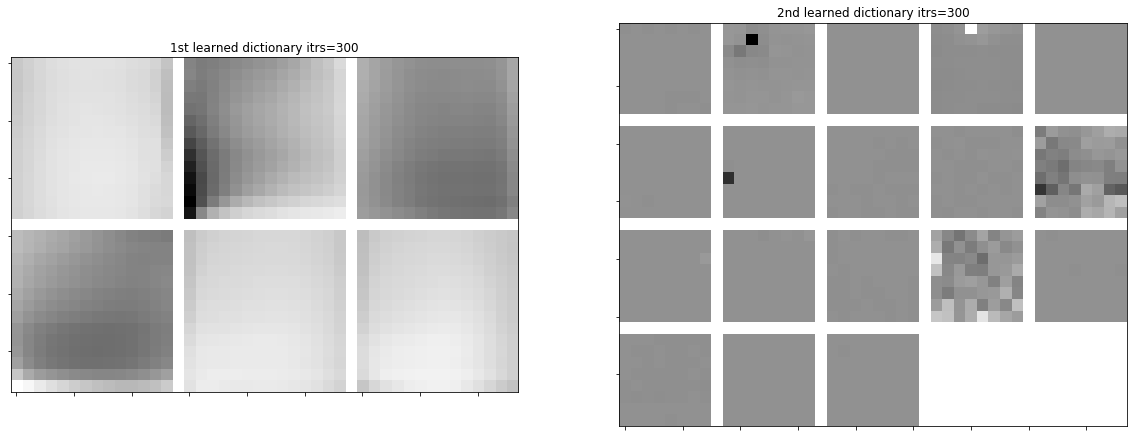

In [18]:
print("l0norm = %i" % np.where(abs(X2.transpose(3,4,2,0,1).squeeze()[0]) ==0, 0, 1).sum())
# 学習前と学習後の辞書の可視化
fig =  plot.figure(figsize=(20, 20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
plot.imview(util.tiledict(D1.squeeze()), fig=fig, ax=ax1, title="1st learned dictionary itrs="+str(itrs))
# plot.imview(util.tiledict(D2.squeeze()), fig=fig, ax=ax1, title="1st learned dictionary itrs="+str(itrs))
plot.imview(util.tiledict(
            D2.squeeze().transpose(0,1,3,2).reshape((D.shape[0], D.shape[1], cri_train.Cd*cri_train.M))
            ), fig=fig, ax=ax2, title="2nd learned dictionary itrs="+str(itrs))

In [23]:
# SVMの作成
# train_data, train_label = load_fashion_mnist_train(1000)
print(train_data.shape)
print(D1.shape)
print(X1.shape)
print(train_label.shape)


# 得られた辞書からスパース係数を算出する(１層目)

# (x, y, チャネル数, 画像の枚数, 辞書の枚数)にリシェイプ
S = train_data
cri_train = cnvrep.CSC_ConvRepIndexing(D1.squeeze(), S)
print("cri_test"+"\n"+str(cri_train))
S = np.asarray(S.reshape(cri_train.shpS), dtype=S.dtype)
print(S.shape)
X1 = sugano_solve.convBPDN(cri_train, D1, S, 1e-9, 300, non_nega, True)
print("ConvBPDN solve time: %.2fs" % (end - start))

# # 使う特徴を(データの個数, 特徴量の次元)に整形する
# X_train = X1.transpose(0,1,2,4,3)
# X_train = X_train.reshape(-1,X_train.shape[4])


# 得られた辞書からスパース係数を算出する(2層目)
# (x, y, チャネル数, 画像の枚数, 辞書の枚数)にリシェイプ
# S = X1.transpose(0,1,4,3,2)
S = tf.nn.max_pool2d(X1.transpose(3,4,2,0,1).squeeze(), ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format="NCHW").numpy().transpose(2,3,1,0)
cri_train = cnvrep.CSC_ConvRepIndexing(D2.squeeze(), S)
S = np.asarray(S.reshape(cri_train.shpS), dtype=S.dtype)
# D2_split = np.split(D2, cri_train.Cd, cri_train.axisC)
# S_split = np.split(S, cri_train.C, cri_train.axisC)
# print(D2_split[0].shape)
# print(S_split[0].shape)

# # X2 = []
# # for D,S in zip(D2_split, S_split):
# #   X2.append(sugano_solve.convBPDN(cri_train, D, S, 1e-7, 400, non_nega, True))

# # X2 = np.concatenate(X2, cri_train.axisC)
# print("cri_test"+"\n"+str(cri_train))
X2 = sugano_solve.convBPDN(cri_train, D2, S, 1e-12, 300, non_nega, True)
print("ConvBPDN solve time: %.2fs" % (end - start))

# 使う特徴を(データの個数, 特徴量の次元)に整形する
X_train = X2.transpose(0,1,2,4,3)
X_train = X_train.reshape(-1,X_train.shape[4])
# SVMを学習させる
from sklearn.svm import SVC
clf = SVC(gamma='auto',kernel='linear')
clf.fit(X_train.T, train_label)
print(clf.score(X_train.T, train_label))

(32, 32, 1000)
(14, 14, 1, 1, 6)
(32, 32, 1, 1000, 6)
(1000,)
cri_test
{'C': 1,
 'Cd': 1,
 'K': 1000,
 'M': 6,
 'N': 1024,
 'Nv': (32, 32),
 'axisC': 2,
 'axisK': 3,
 'axisM': 4,
 'axisN': (0, 1),
 'dimC': 0,
 'dimCd': 0,
 'dimK': 1,
 'dimN': 2,
 'shpD': (14, 14, 1, 1, 6),
 'shpS': (32, 32, 1, 1000, 1),
 'shpX': (32, 32, 1, 1000, 6)}
(32, 32, 1, 1000, 1)
c = 0.92396926
sigma = 18.55242353
l0norm = 3903 l0norm = 6144 sigma = 17.14186905
l0norm = 3984 l0norm = 6144 sigma = 15.83856007
l0norm = 4071 l0norm = 6144 sigma = 14.63434263
l0norm = 4144 l0norm = 6144 sigma = 13.52168274
l0norm = 4233 l0norm = 6144 sigma = 12.49361920
l0norm = 4313 l0norm = 6144 sigma = 11.54372009
l0norm = 4406 l0norm = 6144 sigma = 10.66604252
l0norm = 4476 l0norm = 6144 sigma = 9.85509542
l0norm = 4555 l0norm = 6144 sigma = 9.10580523
l0norm = 4630 l0norm = 6144 sigma = 8.41348412
l0norm = 4694 l0norm = 6144 sigma = 7.77380070
l0norm = 4766 l0norm = 6144 sigma = 7.18275288
l0norm = 4840 l0norm = 6144 sigma = 6

In [0]:
print(X2.shape)
print(X_train.shape)
print(X_train.T.shape)
print(train_label.shape)
print(X1.squeeze().shape)
print(D2.squeeze().shape)
print(np.where(abs(X2.transpose(3,4,2,0,1).squeeze()[0]) == 0, 0, 1).sum())

(32, 32, 6, 1000, 6)
(36864, 1000)
(1000, 36864)
(1000,)
(32, 32, 1000, 6)
(14, 14, 6, 6)
12836


In [26]:
# 学習した辞書をテスト
S = test_data
# 得られた辞書からスパース係数を算出する(１層目)
# (x, y, チャネル数, 画像の枚数, 辞書の枚数)にリシェイプ
cri_test = cnvrep.CSC_ConvRepIndexing(D1.squeeze(), S)
print("cri_test"+"\n"+str(cri_test))
S = np.asarray(test_data.reshape(cri_test.shpS), dtype=S.dtype)
# スパースコーディング
start = time.time()
X1 = sugano_solve.convBPDN(cri_test, D1, S, 1e-7, 300, non_nega, True)
end = time.time()
print("ConvBPDN solve time: %.2fs" % (end - start))

# 得られた辞書からスパース係数を算出する(2層目)
# (x, y, チャネル数, 画像の枚数, 辞書の枚数)にリシェイプ
# S = X1.transpose(0,1,4,3,2)
S = tf.nn.max_pool2d(X1.transpose(3,4,2,0,1).squeeze(), ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format="NCHW").numpy().transpose(2,3,1,0)
cri_test = cnvrep.CSC_ConvRepIndexing(D2.squeeze(), S)
S = np.asarray(S.reshape(cri_test.shpS), dtype=S.dtype)
print("cri_test"+"\n"+str(cri_test))
#D2_split = np.split(D2, cri_train.Cd, cri_train.axisC)
S_split = np.split(S, cri_test.K/1000, cri_test.axisK)
X2 = []
start = time.time()
for S in S_split:
  X2.append(sugano_solve.convBPDN(cri_train, D2, S, 1e-12, 300, non_nega, True))
end = time.time()
print("ConvBPDN solve time: %.2fs" % (end - start))
X2 = np.concatenate(X2, cri_train.axisK)
# X2 = sugano_solve.convBPDN(cri_test, D2, S, 1e-7, 200, False, True)

# 使う特徴を(データの個数, 特徴量の次元)に整形する
X_test = X2.transpose(0,1,2,4,3)
X_test = X_test.reshape(-1,X_test.shape[4])
print(clf.score(X_test.T, test_label))

cri_test
{'C': 1,
 'Cd': 1,
 'K': 10000,
 'M': 6,
 'N': 1024,
 'Nv': (32, 32),
 'axisC': 2,
 'axisK': 3,
 'axisM': 4,
 'axisN': (0, 1),
 'dimC': 0,
 'dimCd': 0,
 'dimK': 1,
 'dimN': 2,
 'shpD': (14, 14, 1, 1, 6),
 'shpS': (32, 32, 1, 10000, 1),
 'shpX': (32, 32, 1, 10000, 6)}
c = 0.93784855
sigma = 21.49412992
l0norm = 3729 l0norm = 6144 sigma = 20.15823850
l0norm = 3816 l0norm = 6144 sigma = 18.90537467
l0norm = 3884 l0norm = 6144 sigma = 17.73037814
l0norm = 3949 l0norm = 6144 sigma = 16.62840936
l0norm = 4023 l0norm = 6144 sigma = 15.59492955
l0norm = 4098 l0norm = 6144 sigma = 14.62568200
l0norm = 4178 l0norm = 6144 sigma = 13.71667460
l0norm = 4252 l0norm = 6144 sigma = 12.86416333
l0norm = 4317 l0norm = 6144 sigma = 12.06463687
l0norm = 4399 l0norm = 6144 sigma = 11.31480215
l0norm = 4458 l0norm = 6144 sigma = 10.61157075
l0norm = 4524 l0norm = 6144 sigma = 9.95204620
l0norm = 4597 l0norm = 6144 sigma = 9.33351206
l0norm = 4656 l0norm = 6144 sigma = 8.75342071
l0norm = 4715 l0nor

In [25]:
print(S.shape)

(16, 16, 6, 10000)


In [0]:
 print("l0norm = %i" % np.where(abs(X2.transpose(3,4,2,0,1).squeeze()[0]) < 1e-7, 0, 1).sum())

In [0]:
# 使う特徴を(データの個数, 特徴量の次元)に整形する
X_test = X2.transpose(0,1,2,4,3)
X_test = X_test.reshape(-1,X_test.shape[4])
print(clf.score(X_test.T, test_label))

0.4788


In [0]:
a = [np.arange(16).reshape(4, 4) for i in range(4)]
a = np.concatenate(a, 1)
print(a.shape)

(4, 16)


In [0]:
print(X2.shape)
print(np.where(abs(X2.transpose(3,4,2,0,1).squeeze()[0]) < 1e-4, 0, 1).sum())

(32, 32, 6, 5000, 3)
7218


In [1]:
! git init

Initialized empty Git repository in /content/.git/


In [0]:
! git config --global user.email "gits.sac.arise@gmail.com"

In [0]:
! git config --global user.password "Sandw1ch1919"

In [7]:
! git commit -m "first commit"

On branch master

Initial commit

Untracked files:
	.config/
	myutil.py
	sample_data/
	sugano_solve.py

nothing added to commit but untracked files present


In [8]:
! ls

myutil.py  sample_data	sugano_solve.py
